In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
import os

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
torch.manual_seed(42)
np.random.seed(42)


# Jupyter visualization settings
%config InlineBackend.figure_format = 'retina'
plt.rcParams['axes.unicode_minus'] = False
sns.set_style("whitegrid")

In [2]:
# Define arguments class instead of using argparse
class Args:
    def __init__(self):
        self.batch_size = 64
        self.test_batch_size = 1000
        self.epochs = 10
        self.lr = 1.0
        self.gamma = 0.7

args = Args()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [3]:
# Data transforms and loading
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

dataset1 = datasets.MNIST('../../data', train=True, download=True, transform=transform)
dataset2 = datasets.MNIST('../../data', train=False, transform=transform)
train_loader = DataLoader(dataset1, batch_size=args.batch_size, shuffle=True)
test_loader = DataLoader(dataset2, batch_size=args.test_batch_size, shuffle=False)

In [4]:
# Define the CNN model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output


model = Net().to(device)
optimizer = optim.Adadelta(model.parameters(), lr=args.lr)
scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)

In [5]:
def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    return train_loss / len(train_loader)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    return test_loss / len(test_loader.dataset), correct / len(test_loader.dataset)

In [6]:
# Training loop
lis_train_loss, lis_test_loss = [], []
for epoch in range(1, args.epochs + 1):
    train_loss = train(args, model, device, train_loader, optimizer, epoch)
    test_loss, test_accuracy = test(model, device, test_loader)
    lis_train_loss.append(train_loss)
    lis_test_loss.append(test_loss)
    print(f'Epoch: {epoch}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')
    scheduler.step()

Epoch: 1, Train Loss: 0.1947, Test Loss: 0.0516, Test Accuracy: 0.9831
Epoch: 2, Train Loss: 0.0728, Test Loss: 0.0363, Test Accuracy: 0.9881
Epoch: 3, Train Loss: 0.0523, Test Loss: 0.0337, Test Accuracy: 0.9888
Epoch: 4, Train Loss: 0.0414, Test Loss: 0.0318, Test Accuracy: 0.9896
Epoch: 5, Train Loss: 0.0356, Test Loss: 0.0272, Test Accuracy: 0.9915
Epoch: 6, Train Loss: 0.0313, Test Loss: 0.0279, Test Accuracy: 0.9911
Epoch: 7, Train Loss: 0.0313, Test Loss: 0.0269, Test Accuracy: 0.9915
Epoch: 8, Train Loss: 0.0288, Test Loss: 0.0275, Test Accuracy: 0.9920
Epoch: 9, Train Loss: 0.0271, Test Loss: 0.0274, Test Accuracy: 0.9916
Epoch: 10, Train Loss: 0.0254, Test Loss: 0.0272, Test Accuracy: 0.9912


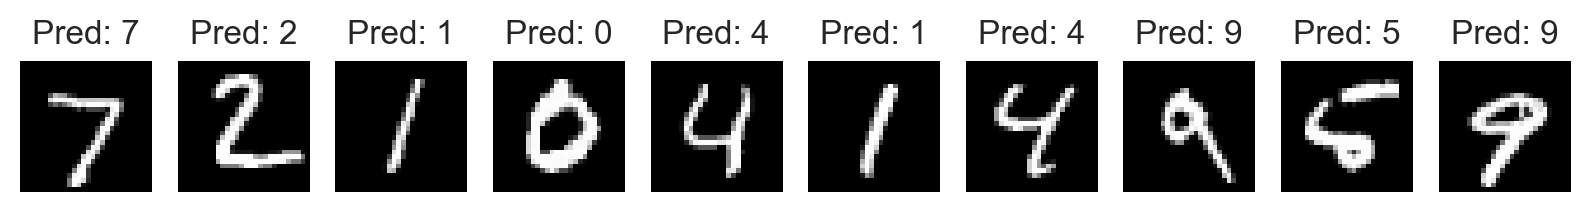

In [7]:
# show 10 test figures and it's predictions
model.eval()
fig, axes = plt.subplots(1, 10, figsize=(10, 2))
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        for i in range(min(10, len(images))):
            axes[i].imshow(images[i].cpu().squeeze(), cmap='gray')
            axes[i].set_title(f'Pred: {preds[i].item()}')
            axes[i].axis('off')
        break
plt.show()